# Movie Classification

* https://machinelearninggeek.com/latent-dirichlet-allocation-using-scikit-learn/
* https://www.kaggle.com/rajmehra03/topic-modelling-using-lda-and-lsa-in-sklearn
* https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
* https://medium.com/swlh/topic-modeling-lda-mallet-implementation-in-python-part-2-602ffb38d396
* https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
* https://colab.research.google.com/drive/1NWj4ioKmqtC1xQkC6opATdGZc27Z9miL

## 1. Web Scrapping

ทำการ Scrape โดยเลือกประเภทหนังเป็น Feature Film ในประเทศอเมริกา ตั้งแต่ปี 2018 ถึง 2021

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
sns.set(style='whitegrid', palette="deep", rc={"figure.figsize": [8, 5]})
%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
from requests import get
from bs4 import BeautifulSoup

page_movie = []

for i in [2018, 2019, 2020, 2021]:
    for j in range(1, 4200, 100):
        url = "https://www.imdb.com/search/title/?title_type=feature&release_date="+str(i)+"-01-01,"+str(i)+"-12-31&countries=us&sort=alpha,asc&count=100&start="+str(j)+"&ref_=adv_nxt"
        response = get(url)
        html_soup = BeautifulSoup(response.text, 'html.parser')
        movie_containers = html_soup.find_all('div', class_ = 'lister-item mode-advanced')

        names = []
        years = []
        genres = []
        descriptions = []

        for container in movie_containers:

            if (container.find('span', attrs = {'class': 'genre'}) is not None) and ((container.find_all('p', attrs={'class':'text-muted'})[-1].text) != '\nAdd a Plot\n'):

                name = container.h3.a.text
                names.append(name)

                year = container.h3.find('span', class_ = 'lister-item-year').text
                years.append(year)

                genre = container.find('span', attrs = {'class': 'genre'}).text
                genres.append(genre)

                description = container.find_all('p', attrs={'class':'text-muted'})[-1].text
                descriptions.append(description)
        test_df = pd.DataFrame({'movie': names,
                                'year': years,
                                'genres': genres,
                                'descriptions': descriptions})
        page_movie.append(test_df)

df = pd.concat(page_movie).reset_index(drop=True)

In [5]:
import pickle
# df.to_pickle('df.pickle')
df = pd.read_pickle('df.pickle')
df.head()

,movie,year,genres,descriptions
0,#1915House,(2018),"\nHorror, Thriller",\nA century of secrets are hidden behind the f...
1,#SquadGoals,(2018),"\nDrama, Thriller","\nSamantha is a serious journalist, both for t..."
2,#Victoria,(2018),"\nAction, Drama",\nVictoria moves from out of town into the poo...
3,1 Angry Black Man,(2018),\nDrama,\nMike Anderson is a senior at the quintessent...
4,"1 Dead man, 6 Suspects, $65 Million",(2018),\nMystery,"\nA low budget but slick ""who done it"" involvi..."


## 2. Data Preparation

In [6]:
df.year.unique()

array(['(2018)', '(I) (2018)', '', '(II) (2018)', '(III) (2018)',
       '(IV) (2018)', '(V) (2018)', '(IX) (2018)', '(XXIII)',
       '(VI) (2018)', '(VIII) (2018)', '(2019)', '(VII)',
       '(XVIII) (2018)', '(I)', '(II)', '(XVI) (2018)', '(II) (2019)',
       '(I) (2019)', '(IV) (2019)', '(V) (2019)', '(III) (2019)',
       '(VI) (2019)', '(VIII) (2019)', '(XXXV) (2019)', '(VII) (2019)',
       '(X) (2019)', '(IX) (2019)', '(XII) (2019)', '(2020)',
       '(III) (2020)', '(II) (2020)', '(I) (2020)', '(XXI) (2020)',
       '(V) (2020)', '(VI) (2020)', '(IV) (2020)', '(2021)',
       '(VIII) (2020)', '(XI) (2020)', '(I) (2021)', '(II) (2021)',
       '(IV) (2021)', '(XII) (2021)', '(III) (2021)', '(VI) (2021)',
       '(V) (2021)', '(VI)'], dtype=object)

In [7]:
df.year = df.year.str.extract('(\d+)')
df.year = df.year.ffill(axis = 0)
df.year.unique()

array(['2018', '2019', '2020', '2021'], dtype=object)

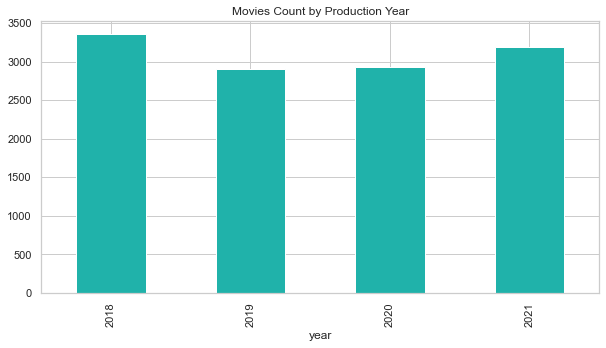

In [5]:
df.groupby(['year']).size().plot(kind='bar', color={'#20B2AA'}, figsize=(10,5), title='Movies Count by Production Year')

In [8]:
df.genres = df.genres.str.strip()
df.head()

,movie,year,genres,descriptions
0,#1915House,2018,"Horror, Thriller",\nA century of secrets are hidden behind the f...
1,#SquadGoals,2018,"Drama, Thriller","\nSamantha is a serious journalist, both for t..."
2,#Victoria,2018,"Action, Drama",\nVictoria moves from out of town into the poo...
3,1 Angry Black Man,2018,Drama,\nMike Anderson is a senior at the quintessent...
4,"1 Dead man, 6 Suspects, $65 Million",2018,Mystery,"\nA low budget but slick ""who done it"" involvi..."


In [9]:
genres = df.genres.tolist()
genres = ", ".join(genres)
genres = sorted(list(set(genres.split(", "))))
genres


['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western']

In [10]:
for g in genres:
  df[g] = df["genres"].apply(lambda x: 1 if len(set(x.split(", ")).intersection(set([g]))) > 0 else 0)
df.head(10)

,movie,year,genres,descriptions,Action,Adventure,Animation,Biography,Comedy,Crime,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
0,#1915House,2018,"Horror, Thriller",\nA century of secrets are hidden behind the f...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,#SquadGoals,2018,"Drama, Thriller","\nSamantha is a serious journalist, both for t...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,#Victoria,2018,"Action, Drama",\nVictoria moves from out of town into the poo...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1 Angry Black Man,2018,Drama,\nMike Anderson is a senior at the quintessent...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"1 Dead man, 6 Suspects, $65 Million",2018,Mystery,"\nA low budget but slick ""who done it"" involvi...",0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,1/1,2018,Drama,"\nMaybe pregnant, 20 years old Lissa revises h...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,10-56,2018,Drama,\nA group of friends go to an island to detox ...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,11 Henrys,2018,Sci-Fi,\nThree parallel versions of the same man (a S...,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,111: The Sunriser,2018,Drama,\nN.Y.P.D. Detective James Morris hunts his yo...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,12 Strong,2018,"Action, Drama, History",\n12 Strong tells the story of the first Speci...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12388 entries, 0 to 12387
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movie         12388 non-null  object
 1   year          12388 non-null  object
 2   genres        12388 non-null  object
 3   descriptions  12388 non-null  object
 4   Action        12388 non-null  int64 
 5   Adventure     12388 non-null  int64 
 6   Animation     12388 non-null  int64 
 7   Biography     12388 non-null  int64 
 8   Comedy        12388 non-null  int64 
 9   Crime         12388 non-null  int64 
 10  Drama         12388 non-null  int64 
 11  Family        12388 non-null  int64 
 12  Fantasy       12388 non-null  int64 
 13  Game-Show     12388 non-null  int64 
 14  History       12388 non-null  int64 
 15  Horror        12388 non-null  int64 
 16  Music         12388 non-null  int64 
 17  Musical       12388 non-null  int64 
 18  Mystery       12388 non-null  int64 
 19  News

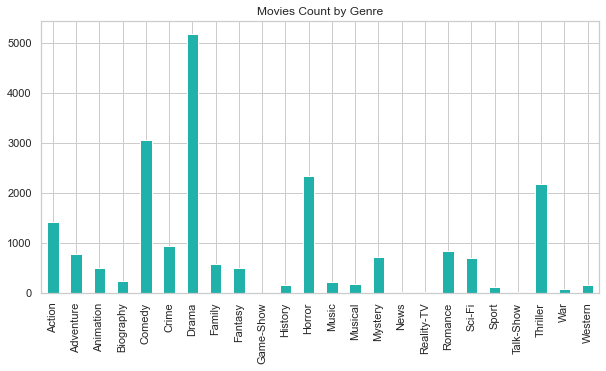

In [10]:
df.loc[:, genres].sum().plot(kind='bar', color={'#20B2AA'}, figsize=(10, 5), title='Movies Count by Genre')

In [12]:
import re
df.corpus = df.descriptions.str.strip()
df.corpus = df.corpus.str.replace('...                See full summary\xa0»', '', regex=True)
df.corpus = df.corpus.str.lower()
df.corpus = df.corpus.map(lambda x: re.sub('[,\.!?():;$%&*/@#^+=~_{}<>]', '', x))
df.corpus = df.corpus.map(lambda x: re.sub('[`]', '', x))
df.corpus = df.corpus.map(lambda x: re.sub("[']", '', x))
df.corpus = df.corpus.map(lambda x: re.sub('["]', '', x))
df.corpus.tolist()


['a century of secrets are hidden behind the fresh paint and modern additions peeling back the layers is letting something escape and he might not see it till its too late',
 'samantha is a serious journalist both for the school paper and for the yearbook but shes just as serious about her friends nate gillian and rudy all of whom are vying with her for a full-ride local scholarship to college',
 'victoria moves from out of town into the poor inner city of new york with her father the neighborhood drug dealer she goes on a journey seeking answers justice and revenge after her ',
 'mike anderson is a senior at the quintessential new-england liberal arts school frost college and mike is eight weeks away from graduation on this particular day he has his ',
 'a low budget but slick who done it involving the murder of a wealthy businessman the long list of suspects includes the family butler their shady attorney and an assortment of greedy ',
 'maybe pregnant 20 years old lissa revises her 

In [13]:
import nltk
from nltk.stem.porter import *
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *


def stopword_removal(x, stpws=stopwords.words("english")):
  return list(set(x).difference(set(stpws)))


def lemmatization(x, stemmer=PorterStemmer()):
  return [stemmer.stem(i) for i in x]


def number_removal(x):
  return [i for i in x if not i.isnumeric()]

df.corpus = df.corpus.apply(lambda x: word_tokenize(x))
df.corpus = df.corpus.apply(lambda x: stopword_removal(x))
df.corpus = df.corpus.apply(lambda x: lemmatization(x))
df.corpus = df.corpus.apply(lambda x: number_removal(x))
df.corpus = df.corpus.apply(lambda x: " ".join(x))
df.corpus.tolist()


['peel let secret addit hidden till fresh see escap layer paint someth modern late might back centuri behind',
 'she colleg rudi samantha seriou nate school scholarship local gillian full-rid paper journalist vy friend yearbook',
 'goe move drug york answer reveng neighborhood dealer seek new inner town justic citi victoria journey father poor',
 'senior day away graduat colleg eight mike week school new-england particular art frost quintessenti anderson liber',
 'attorney long shadi wealthi budget assort famili greedi slick murder low involv butler done suspect includ list businessman',
 'life year old lissa pregnant mayb revis',
 'problem detox struggl face togeth realiz go friend group island',
 'scientist shift version artist intellig live three parallel whim spi man other mysteri',
 'panther valdez member feder parti compromis jame ralphi morriss brother undercov detect hunt younger status111 partnerlov nypd black morri',
 'work tell first take warlord stori must afghanistan leade

## Splitting Dataset

In [14]:
from sklearn.model_selection import train_test_split
y = df.loc[:, genres].values
X_train, X_test, y_train, y_test = train_test_split(df.corpus, y, test_size=0.2, random_state=42)
print('X_train size: {}, X_test size: {}'.format(X_train.shape, X_test.shape))

X_train size: (9910,), X_test size: (2478,)


## TFIDF Vetorization

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_train_tfidf = X_train_tfidf.toarray()

X_test_tfidf = vectorizer.transform(X_test)
X_test_tfidf = X_test_tfidf.toarray()


In [138]:
X_train_tfidf


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [103]:
print('X_train_tfidf size: {}, X_test_tfidf size: {}'.format(X_train_tfidf.shape, X_test_tfidf.shape))

X_train_tfidf size: (9910, 1000), X_test_tfidf size: (2478, 1000)


## Classification without LDA

In [72]:
from sklearn.multiclass import OneVsRestClassifier


### Naive Bayes

In [139]:
from sklearn.naive_bayes import GaussianNB
nb = make_pipeline(StandardScaler(), GaussianNB())
nb = OneVsRestClassifier(nb)
nb.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=Pipeline(steps=[('gaussiannb', GaussianNB())]))

In [140]:
from sklearn.metrics import f1_score
y_pred_nb = nb.predict(X_test_tfidf)
print('F1-score of Naive Bayes: ' + str(round(f1_score(y_test, y_pred_nb, average='micro')*100, 2)) + '%')

F1-score of Naive Bayes: 25.69%


### Logistic Regression

In [143]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
lr = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
lr = OneVsRestClassifier(lr)
lr.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(random_state=42))]))

In [144]:
from sklearn.metrics import f1_score
y_pred_lr = lr.predict(X_test_tfidf)
print('F1-score Logistric Regression: ' + str(round(f1_score(y_test, y_pred_lr, average='micro')*100, 2)) + '%')

F1-score Logistric Regression: 38.47%


### K-Nearest Neighobr

In [128]:
from sklearn.neighbors import KNeighborsClassifier
knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
knn.fit(X_train_tfidf, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [129]:
from sklearn.metrics import f1_score
y_pred_knn = knn.predict(X_test_tfidf)
print('F1-score K-Nearest Neighbour: ' + str(round(f1_score(y_test, y_pred_knn, average='micro')*100, 2)) + '%')

F1-score K-Nearest Neighbour: 7.28%


### Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svc = make_pipeline(StandardScaler(), SVC())
svc = OneVsRestClassifier(svc)
svc.fit(X_train_tfidf, y_train)

In [ ]:
from sklearn.metrics import f1_score
y_pred_svc = svc.predict(X_test_tfidf)
print('F1-score Support Vector Machine: ' + str(round(f1_score(y_test, y_pred_svc, average='micro')*100, 2)) + '%')

### Decision Tree

In [132]:
from sklearn.tree import DecisionTreeClassifier
dt = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=42))
dt.fit(X_train_tfidf, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [133]:
from sklearn.metrics import f1_score
y_pred_dt = dt.predict(X_test_tfidf)
print('F1-score Support Vector Machine: ' + str(round(f1_score(y_test, y_pred_dt, average='micro')*100, 2)) + '%')

F1-score Support Vector Machine: 32.07%


### Random Forest

In [97]:
from sklearn.ensemble import RandomForestClassifier
rf = make_pipeline(StandardScaler(),RandomForestClassifier(random_state=42))
rf.fit(X_train_tfidf, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [122]:
from sklearn.metrics import f1_score
y_pred_rf = rf.predict(X_test_tfidf)
print('F1-score: ' + str(round(f1_score(y_test, y_pred_rf, average='micro')*100, 2)) + '%')

F1-score: 31.3%


### XGBoost

In [136]:
from xgboost import XGBClassifier
xgb = make_pipeline(StandardScaler(), XGBClassifier(random_state=42, eval_metric='mlogloss'))
xgb = OneVsRestClassifier(xgb)
xgb.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('xgbclassifier',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             eval_metric='mlogloss',
                                                             gamma=None,
                                                             gpu_id=None,
                                                             importance_type='gain',
                                                             interaction_constrain

In [137]:
from sklearn.metrics import f1_score
y_pred_xgb = xgb.predict(X_test_tfidf)
print('F1-score: ' + str(round(f1_score(y_test, y_pred_xgb, average='micro')*100, 2)) + '%')

F1-score: 33.67%


## Classification with LDA

In [155]:
from sklearn.decomposition import LatentDirichletAllocation

#สร้าง model LDA โดยกำหนดจำนวน topics = 20
lda = LatentDirichletAllocation(n_components=20, random_state=42)

#Fit และ Transform
X_train_lda = lda.fit_transform(X_train_tfidf)
X_test_lda = lda.transform(X_test_tfidf)

lda_components = lda.components_
terms = vectorizer.get_feature_names()

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key = sorted(zipped, key=lambda t: t[1], reverse=True)[:7]
    top_terms_list = list(dict(top_terms_key).keys())
    print("Topic "+str(index+1)+": ", top_terms_list)

Topic 1:  ['famili', 'brother', 'find', 'life', 'mother', 'year', 'daughter']
Topic 2:  ['that', 'santa', 'master', 'land', 'la', 'realli', 'north']
Topic 3:  ['killer', 'drug', 'serial', 'reveng', 'crime', 'deal', 'murder']
Topic 4:  ['full', 'term', 'legend', 'captur', 'transform', 'see', 'come']
Topic 5:  ['holiday', 'christma', 'danc', 'year', 'littl', 'anim', 'five']
Topic 6:  ['journey', 'life', 'young', 'musician', 'find', 'author', 'stori']
Topic 7:  ['organ', 'far', 'quest', 'futur', 'person', 'goe', 'shadow']
Topic 8:  ['agent', 'plot', 'releas', 'prison', 'retir', 'investig', 'john']
Topic 9:  ['murder', 'found', 'miss', 'kidnap', 'investig', 'killer', 'may']
Topic 10:  ['school', 'high', 'student', 'differ', 'senior', 'bulli', 'act']
Topic 11:  ['cross', 'win', 'path', 'town', 'convinc', 'hunter', 'enter']
Topic 12:  ['post', 'navig', 'earli', 'stand', 'apocalypt', 'world', 'inhabit']
Topic 13:  ['angel', 'lo', 'earth', 'must', 'human', 'alien', 'race']
Topic 14:  ['stori',

In [183]:
nb_lda = make_pipeline(StandardScaler(), GaussianNB())
nb_lda = OneVsRestClassifier(nb)
nb_lda.fit(X_train_lda, y_train)
y_pred_nb_lda = nb_lda.predict(X_test_lda)
sc_nb_lda = f1_score(y_test, y_pred_nb_lda, average='micro')
print('F1-score of Naive Bayes with LDA: ' + str(round(sc_nb_lda*100, 2)) + '%')

F1-score of Naive Bayes with LDA: 22.92%


In [181]:
lr_lda = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
lr_lda = OneVsRestClassifier(lr)
lr_lda.fit(X_train_lda, y_train)
y_pred_lr_lda = lr_lda.predict(X_test_lda)
sc_lr_lda = f1_score(y_test, y_pred_lr_lda, average='micro')
print('F1-score of Logistic Regression with LDA: ' + str(round(sc_lr_lda*100, 2)) + '%')

F1-score of Logistic Regression with LDA: 11.29%


In [179]:
knn_lda = make_pipeline(StandardScaler(), KNeighborsClassifier())
knn_lda.fit(X_train_lda, y_train)
y_pred_knn_lda = knn_lda.predict(X_test_lda)
sc_knn_lda = f1_score(y_test, y_pred_knn_lda, average='micro')
print('F1-score of K-Nearest Neighbor with LDA: ' + str(round(sc_knn_lda*100, 2)) + '%')

F1-score of K-Nearest Neighbor with LDA: 20.63%


In [169]:
#svm

In [177]:
dt_lda = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=42))
dt_lda.fit(X_train_lda, y_train)
y_pred_dt_lda = dt_lda.predict(X_test_lda)
sc_dt_lda = f1_score(y_test, y_pred_dt_lda, average='micro')
print('F1-score of Decision Tree with LDA: ' + str(round(sc_dt_lda*100, 2)) + '%')

F1-score of Decision Tree with LDA: 23.15%


In [173]:
rf_lda = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
rf_lda.fit(X_train_lda, y_train)
y_pred_rf_lda = rf_lda.predict(X_test_lda)
sc_rf_lda = f1_score(y_test, y_pred_rf_lda, average='micro')
print('F1-score of Random Forest with LDA: ' + str(round(sc_rf_lda*100, 2)) + '%')

F1-score of Random Forest with LDA: 16.05%


In [175]:
xgb_lda = make_pipeline(StandardScaler(), XGBClassifier(random_state=42, eval_metric='mlogloss'))
xgb_lda = OneVsRestClassifier(xgb_lda)
xgb_lda.fit(X_train_lda, y_train)
y_pred_xgb_lda = xgb_lda.predict(X_test_lda)
sc_xgb_lda = f1_score(y_test, y_pred_xgb_lda, average='micro')
print('F1-score of XGBoost with LDA: ' + str(round(sc_xgb_lda*100, 2)) + '%')

F1-score of XGBoost with LDA: 17.9%
